# NLP with NLTK and Word2Vec

Here we're working with the preprocessed movies dataset to figure out how to map these descriptions into some subspace of interest.

In [13]:
import gensim
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [253]:
import word2vectorizer as w2v

#### NLTK packages

In [14]:
nltk.download('punkt')
# download stop words using nltk
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/Greg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Greg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Import NLP dataset

In [116]:
df = (pd.read_csv("df__nlp.csv", header=0, sep=',', encoding='latin-1')
    .dropna(subset=['title', 'id', 'overview'])
    .drop('original_title', axis=1)
    .set_index('title'))

In [117]:
df.sample(10)

,id,overview,tagline,original_language
title,,,,
Mission: Impossible - Rogue Nation,177677,Ethan and team take on their most impossible m...,Desperate Times. Desperate Measures.,en
The Killer Is Loose,27999,"A savings-and-loan bank is robbed; later, a po...",He was no ordinary killer... She was no ordina...,en
Blithe Spirit,19072,An English mystery novelist invites a medium t...,One Wife Too Many,en
Lola,77925,A middle aged writer of pornographic novels me...,It may be love... but it's definitely exhausting!,en
House of the Dead,11059,"Set on an island off the coast, a techno rave ...",You won't last the night.,en
The Long Goodbye,1847,Detective Philip Marlowe tries to help a frien...,Nothing says goodbye like a bullet...,en
Life Begins for Andy Hardy,43793,"With his high school graduation behind him, An...",Mickey woos! Judy sings! Best Hardy hit yet!,en
Marvin's Room,9819,A leukemia patient attempts to end a 20-year f...,A story about the years that keep us apart... ...,en
Trance,68727,"A fine art auctioneer mixed up with a gang, jo...",Don't be a hero.,en


In [118]:
print(df.shape)

(17945, 4)


### Set to lowercase

In [145]:
df['overview'] = df['overview'].str.lower()
df['tagline'] = df['tagline'].str.lower()

### Remove fullstop endings

In [146]:
df.loc[df['overview'].str.endswith('.'), 'overview'] = df.loc[df['overview'].str.endswith('.'), 'overview'].str[:-1]
df.loc[df['tagline'].str.endswith('.'), 'tagline'] = df.loc[df['tagline'].str.endswith('.'), 'tagline'].str[:-1]

### Tokenize sentences

In [121]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [155]:
df['tokened'] = (df['overview'] + df['tagline']).apply(tokenizer.tokenize).apply(lambda x: ' '.join(x))

### Expand

In [157]:
# expand out
overview_exp = df['tokened'].str.split(" ", expand=True)

### Using NLTK corpora of English *stop words* to filter

In [158]:
from nltk.corpus import stopwords

In [159]:
stop = stopwords.words('english')

In [160]:
filter_w = "^(?:" + "|".join(stop).replace("'", "\'") + '|\s)$'

In [161]:
filter_w

"^(?:i|me|my|myself|we|our|ours|ourselves|you|you're|you've|you'll|you'd|your|yours|yourself|yourselves|he|him|his|himself|she|she's|her|hers|herself|it|it's|its|itself|they|them|their|theirs|themselves|what|which|who|whom|this|that|that'll|these|those|am|is|are|was|were|be|been|being|have|has|had|having|do|does|did|doing|a|an|the|and|but|if|or|because|as|until|while|of|at|by|for|with|about|against|between|into|through|during|before|after|above|below|to|from|up|down|in|out|on|off|over|under|again|further|then|once|here|there|when|where|why|how|all|any|both|each|few|more|most|other|some|such|no|nor|not|only|own|same|so|than|too|very|s|t|can|will|just|don|don't|should|should've|now|d|ll|m|o|re|ve|y|ain|aren|aren't|couldn|couldn't|didn|didn't|doesn|doesn't|hadn|hadn't|hasn|hasn't|haven|haven't|isn|isn't|ma|mightn|mightn't|mustn|mustn't|needn|needn't|shan|shan't|shouldn|shouldn't|wasn|wasn't|weren|weren't|won|won't|wouldn|wouldn't|\\s)$"

## Filter out words

In [162]:
repl = overview_exp.replace(filter_w, np.nan, regex=True).replace('', np.nan)

In [163]:
list_lists = repl.apply(lambda x: x.str.cat(sep=';'), axis=1).str.split(';')

In [164]:
print(repl.shape)
repl.head()

(17945, 212)


,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
title,,,,,,,,,,,,,,,,,,,,,
Jumanji,NaN,siblings,judy,NaN,peter,discover,NaN,enchanted,board,game,...,NaN,None,NaN,None,None,NaN,None,NaN,NaN,None
Grumpier Old Men,NaN,family,wedding,reignites,NaN,ancient,feud,NaN,next,door,...,NaN,None,NaN,None,None,NaN,None,NaN,NaN,None
Waiting to Exhale,cheated,NaN,mistreated,NaN,stepped,NaN,NaN,women,NaN,holding,...,NaN,None,NaN,None,None,NaN,None,NaN,NaN,None
Father of the Bride Part II,NaN,NaN,george,banks,NaN,recovered,NaN,NaN,daughter,NaN,...,NaN,None,NaN,None,None,NaN,None,NaN,NaN,None
Heat,obsessive,master,thief,neil,mccauley,leads,NaN,top,notch,crew,...,NaN,None,NaN,None,None,NaN,None,NaN,NaN,None


In [165]:
word2vec_ready = list_lists.tolist()

## Deploying Word2Vec

In [166]:
model = gensim.models.Word2Vec(word2vec_ready, min_count=2, size=100, workers=3, window=5, sg=1)

In [167]:
X = model.wv[model.wv.vocab]

In [168]:
# model.wv.save_word2vec_format('word2vec_model.bin')

In [243]:
Y = gensim.models.KeyedVectors.load_word2vec_format('word2vec_model.bin')

### Project using PCA

In [169]:
from sklearn.decomposition import PCA

In [170]:
pca_t = PCA(2).fit_transform(X)

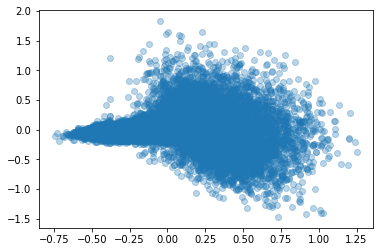

In [171]:
plt.scatter(pca_t[:, 0], pca_t[:, 1],alpha=.3)
plt.show()

### Most similar

In [191]:
import itertools as it

In [182]:
model.wv.similarity('chess', 'poker')

0.8769528

In [ ]:
def link_url_to_words(url):
    

In [256]:
example_word = ['hairless cat', 
                'traditional sport',
                'volcanic landform', 
                'small terrier']

In [262]:
def link_words_to_movie(w):
    """Take a list of words and get predicted close words from NLTK"""
    assert isinstance(w, (list, tuple)), "w must be a list"
    res_l = list(it.chain.from_iterable([nltk.word_tokenize(word) for word in w]))
    skipped_res = [s for s in res_l if s in model.wv.vocab]
    print(skipped_res)
    _w = model.wv.most_similar(skipped_res, topn=100)
    _top_w = _w[:10]
    #print(_w)
    print(_top_w)
    return list(dict(_top_w).keys())

In [264]:
tw = link_words_to_movie(example_word)

['cat', 'traditional', 'sport', 'volcanic', 'small', 'terrier']
[('grove', 0.9795904159545898), ('virtually', 0.9793041944503784), ('warlock', 0.978966236114502), ('draw', 0.9788894653320312), ('gunslingers', 0.9764358401298523), ('picturesque', 0.9761002063751221), ('firecreek', 0.9752250909805298), ('moderate', 0.9749740362167358), ('unsupervised', 0.9742239713668823), ('delphi', 0.974073052406311)]


In [265]:
tw

['grove',
 'virtually',
 'warlock',
 'draw',
 'gunslingers',
 'picturesque',
 'firecreek',
 'moderate',
 'unsupervised',
 'delphi']

In [282]:
for word in tw:
    df['tokened'].str.contains(word)

In [261]:
nltk.word_tokenize(example_word[0])

['hairless', 'cat']

In [278]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [279]:
vec = TfidfVectorizer(stop_words='english')
X_t = vec.fit_transform(df['tokened'].tolist())

In [280]:
X_t

<17945x56570 sparse matrix of type '<class 'numpy.float64'>'
	with 537053 stored elements in Compressed Sparse Row format>

In [281]:
X_t.shape

(17945, 56570)

In [293]:
df

,id,overview,tagline,original_language,overview_tokens,tokened
title,,,,,,
Jumanji,8844,when siblings judy and peter discover an encha...,roll the dice and unleash the excitement!,en,when siblings judy and peter discover an encha...,when siblings judy and peter discover an encha...
Grumpier Old Men,15602,a family wedding reignites the ancient feud be...,still yelling. still fighting. still ready for...,en,a family wedding reignites the ancient feud be...,a family wedding reignites the ancient feud be...
Waiting to Exhale,31357,"cheated on, mistreated and stepped on, the wom...",friends are the people who let you be yourself...,en,cheated on mistreated and stepped on the women...,cheated on mistreated and stepped on the women...
Father of the Bride Part II,11862,just when george banks has recovered from his ...,just when his world is back to normal... he's ...,en,just when george banks has recovered from his ...,just when george banks has recovered from his ...
Heat,949,"obsessive master thief, neil mccauley leads a ...",a los angeles crime saga,en,obsessive master thief neil mccauley leads a t...,obsessive master thief neil mccauley leads a t...
...,...,...,...,...,...,...
Pooh's Heffalump Halloween Movie,14885,"it's halloween in the 100 acre wood, and roo's...",celebrate lumpy's first halloween,en,it s halloween in the 100 acre wood and roo s ...,it s halloween in the 100 acre wood and roo s ...
The Morning After,420346,the morning after is a feature film that consi...,what happened last night?,en,the morning after is a feature film that consi...,the morning after is a feature film that consi...
House of Horrors,84419,an unsuccessful sculptor saves a madman named ...,meet...the creeper!,en,an unsuccessful sculptor saves a madman named ...,an unsuccessful sculptor saves a madman named ...
